# Intro to Data Analysis final Project

# Introduction

The titanic is the most famous example for the application of the 'Birkenhead Drill', the notion of 'women and children first' (Wikipedia). Since the data dictionary states, that 'Pclass' (ticket class) is a proxy for socioeconomic class, we can ask the question whether 'women and children first' is true for all classes or only the poor. Secondly, we can check if class reflects in other variables such as the paid fare.
First, we will prepare our data for analysis, then we will show that there is indeed strong evidence for 'women and children first'. Finally, we will show that 'Pclass' is not a good proxy for ticket price and port of embarkation. Especially since the difference of fares is much less across classes than one would expect.

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels
%pylab inline
#Styling 
sns.set_style("whitegrid")
killa_palette=["#53b0bd","#d1b185", "#8d7b92","#8abca7","#FF6347", "#12646f"]
sns.set_palette(killa_palette)

#read in the data
file= '/Users/mpfeifer/Projekte/udacity/IntroToDataAnalysis/titanic-data.csv'
oridata = pd.read_csv(file,index_col='PassengerId')
data = pd.read_csv(file,index_col='PassengerId')



Populating the interactive namespace from numpy and matplotlib


## Data Preparation

Before we start the analysis, we need to prepare the data. First, we drop the columns 'Name', 'cabin' and 'Ticket' since they do not hold any information that would help us answer our questions. 

In [2]:
#delete columns we do not need
del data['Name']
del data['Ticket']

Next, we take a look at the data and look for missing values.

In [3]:
print(data.describe())
print("")
print(data.info())

         Survived      Pclass         Age       SibSp       Parch        Fare
count  891.000000  891.000000  714.000000  891.000000  891.000000  891.000000
mean     0.383838    2.308642   29.699118    0.523008    0.381594   32.204208
std      0.486592    0.836071   14.526497    1.102743    0.806057   49.693429
min      0.000000    1.000000    0.420000    0.000000    0.000000    0.000000
25%      0.000000    2.000000   20.125000    0.000000    0.000000    7.910400
50%      0.000000    3.000000   28.000000    0.000000    0.000000   14.454200
75%      1.000000    3.000000   38.000000    1.000000    0.000000   31.000000
max      1.000000    3.000000   80.000000    8.000000    6.000000  512.329200

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 9 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare

'Embarked' has two missing values and 'Age' about 180. We could either just drop all the observations with missing data, as is frequently done in academia to not distort the results. Or we could try and fill the missing data points with values in a way that it does not change the distribution of the observed data. In other words, create data after our best guess of what the data would most likely look like.
'Embarked' is not that critical, because there are only two values missing. We can just fill it with the most common value, or the mode:

In [4]:
#check for most common value
print('Mode of "Embarked"')
data.Embarked.mode()

Mode of "Embarked"


0    S
dtype: object

Most passengers got aboard in Southhampton, so we fill the missing values with 'S'.

In [5]:
#fill NaNs with most common value
data.Embarked = data.Embarked.fillna(data.Embarked.mode())

With 'Age' we can not just fill the missing data with the mode, that would certainly distort our data. What we can do instead, is to mimic the actual distribution of the data. 
First, we create an array of random numbers in a range between one standard deviation below and one std above the mean. We fill it with as many values, as there are missing values in our data. Then, we fill the NaNs with the values from our array.
Note, that this approach assumes that the data is more or less normally distributet, because it will add roughly the same amount of values above and below the mean. Also, it will decrease the width of the data a bit, since we only add values around the center of the data. 
A decent metric to determine whether this approach fits the data, is to compare the means of the original data and the altered data. The smaller the difference, the better it worked.

C:\Users\mpfeifer\Apps\Anaconda3\envs\DAND\lib\site-packages\ipykernel\__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Original mean:29.6991176471 New mean:29.4006734007


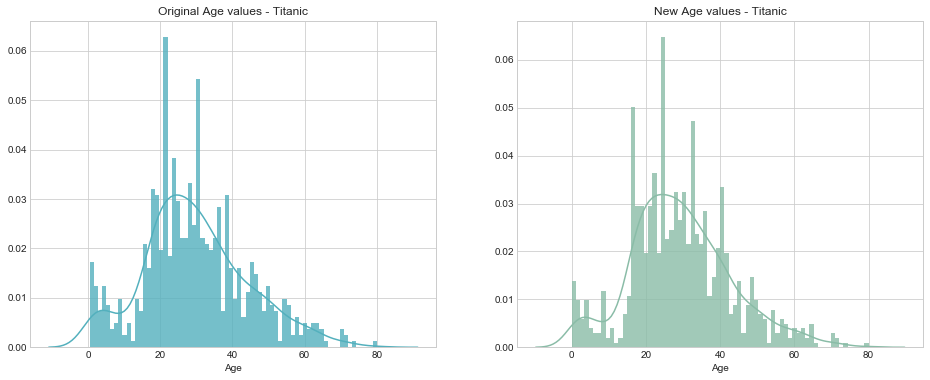

In [6]:
"""
I found this way to clean the data here: https://www.kaggle.com/omarelgabry/a-journey-through-titanic
I liked it more than my original approach, so I used this method instead.
"""


#get mean std and count NaNs
mean_age   = data["Age"].mean()
std_age       = data["Age"].std()
nan_age = data["Age"].isnull().sum()

#generate random numbers within one std from the mean
rand = np.random.randint(mean_age - std_age, mean_age + std_age, size = nan_age)

#replace NaNs with random numbers and convert to integer
data["Age"][np.isnan(data["Age"])] = rand
data['Age'] = data['Age'].astype(int)

#plot original data and data with random numbers to compare distribution
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(16,6))
axis1.set_title('Original Age values - Titanic')
axis2.set_title('New Age values - Titanic')
sns.distplot(oridata.Age.dropna(), bins=70,ax=axis1, hist_kws=dict(alpha=.8))
sns.distplot(data.Age, bins=70,ax=axis2, hist_kws=dict(alpha=.8), color="#8abca7")
print 'Original mean:'+str(oridata.Age.mean())+' New mean:'+str(data.Age.mean())


We see that the mean changed slightliy. This is only a very small change, so we will use the data we created.
Now we check our data again.

In [7]:
#Check if the data is clean
print(data.describe())
print("")
print(data.info())
print("")
print("")
print('Data is cleaned')

         Survived      Pclass         Age       SibSp       Parch        Fare
count  891.000000  891.000000  891.000000  891.000000  891.000000  891.000000
mean     0.383838    2.308642   29.400673    0.523008    0.381594   32.204208
std      0.486592    0.836071   13.545345    1.102743    0.806057   49.693429
min      0.000000    1.000000    0.000000    0.000000    0.000000    0.000000
25%      0.000000    2.000000   21.000000    0.000000    0.000000    7.910400
50%      0.000000    3.000000   28.000000    0.000000    0.000000   14.454200
75%      1.000000    3.000000   37.000000    1.000000    0.000000   31.000000
max      1.000000    3.000000   80.000000    8.000000    6.000000  512.329200

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 9 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Sex         891 non-null object
Age         891 non-null int32
SibSp       891 non-null int64
Parch       891 non-null int64
Fare  

# Did 'Women and Children first' only apply to the poor?

We start by looking at the age distribution across gender and class both in relative and absolute terms:

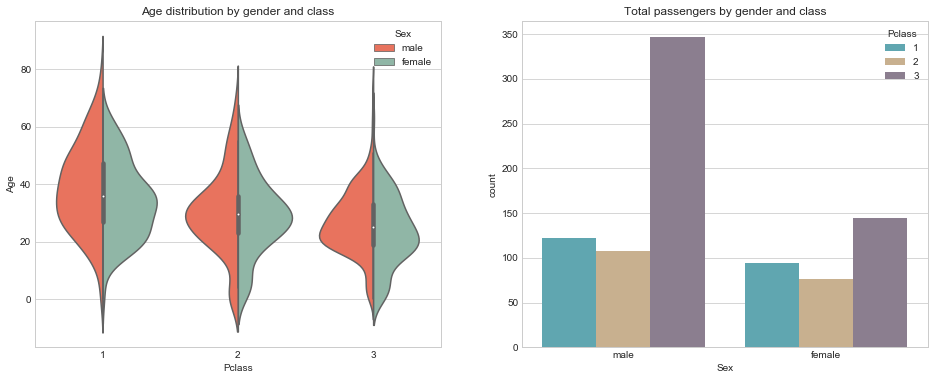

In [8]:
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(16,6))
#Violin plot to show the age distribution by gender and class
axis1.set_title('Age distribution by gender and class')
sns.violinplot(x='Pclass',y='Age', data=data, hue='Sex', split=True, ax=axis1,palette=("#FF6347","#8abca7"))
#barchart to show absolute passenger numbers by gender and class
axis2.set_title('Total passengers by gender and class')
sns.countplot(x="Sex", hue="Pclass", data=data, ax=axis2)

The thing that stands out the most ist the high number of male 3rd class passengers between 20 and 40. Wikipedia states, that the 3rd class of the titanic was largely populated by poor emigrants who wanted to start a new life in the USA. This seems like a fitting explanation. Another interesting point is that there were more passengers in th 1st class than in the 2nd. This could be due to the sample we are using for this analysis.
Next we take a look at survival rates and their respective total numbers.

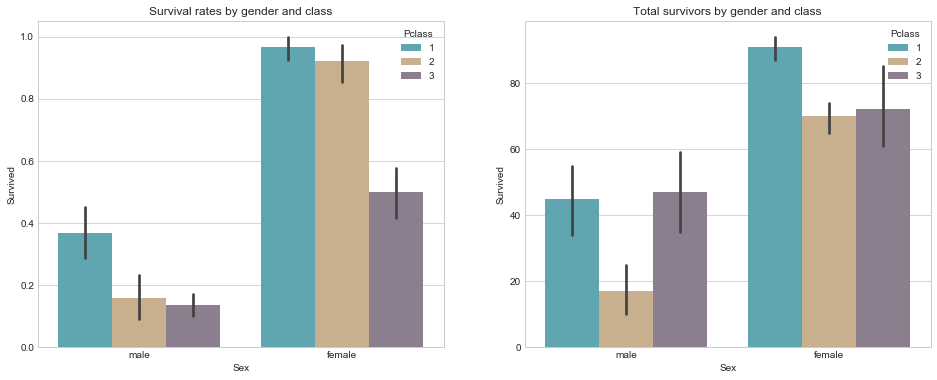

In [9]:
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(16,6))
#barchart to show survival rates by gender and class
axis1.set_title('Survival rates by gender and class')
sns.barplot(x="Sex", y="Survived", hue="Pclass", data=data, ax=axis1)
#barchart to show absolute numbers of survivors by gender and class
axis2.set_title('Total survivors by gender and class')
sns.barplot(x="Sex", y="Survived", hue="Pclass", data=data, estimator=sum, ax=axis2)


We can see, that within their class, females on average were more than twice as likely to survive than their male counterparts. Even third class women were likelier to survive than first class men. Although they had the lowest survival rate, more males from 3rd class survived that from the other two classes, just because there were so many of them as we saw earlier.

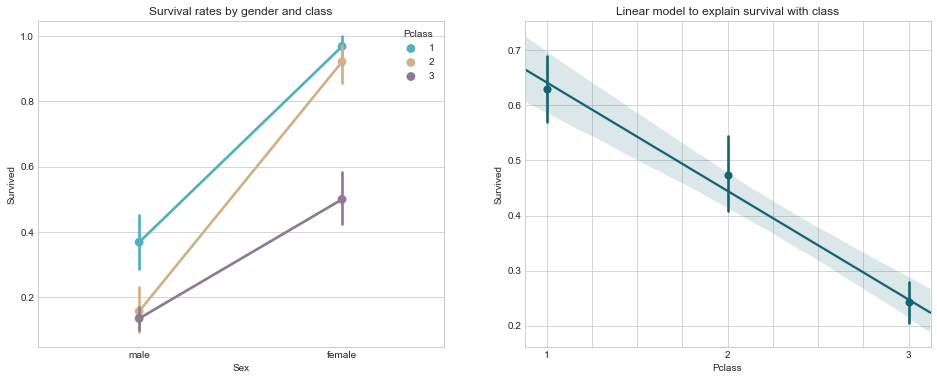

In [10]:
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(16,6))
#Point plot to catch patterns in survival rates by gender and class
axis1.set_title('Survival rates by gender and class')
sns.pointplot(x="Sex", y="Survived", hue="Pclass", data=data,ax=axis1)
#linear model explaining survival rates using only class
axis2.set_title('Linear model to explain survival with class')
axis2.set(xticklabels=[0,1,'','','',2,'','','',3])
sns.regplot(x="Pclass", y="Survived", data=data,x_estimator=np.mean,ax=axis2, color="#12646f")

The first plot shows us the same survival rates as above, but with a point plot instead of a bar chart. This shows us, that 2nd class men survival rates like 3rd class men, while 2nd class females had almost the same chances as 1st class females. The second chart shows us, that overall survival can be explaied pretty well just by using class.
So what happens when we also take children into account? To do this, we every passenger under 14 as child and then look at survival rates of children alone and women and children together.

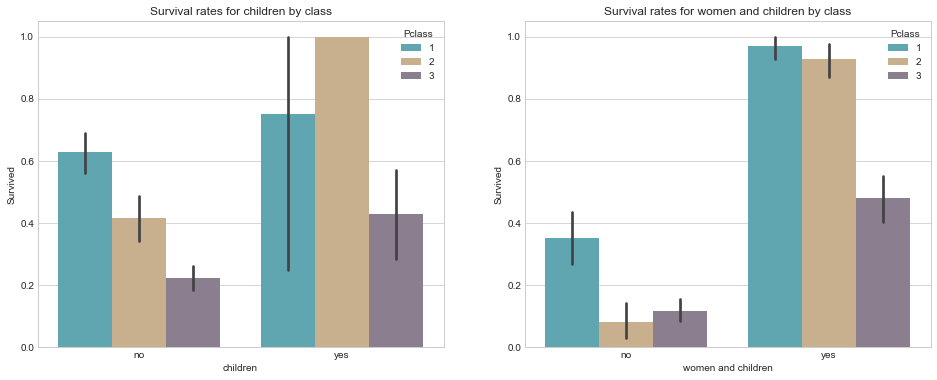

In [11]:
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(16,6))
#definition of a 'child' variable and a barchart to show survival rates for children by class
data['child']='no'
data.loc[data.Age < 14, 'child'] = 'yes'
axis1.set_title('Survival rates for children by class')
sns.barplot(x="child", y="Survived", hue="Pclass", data=data,ax=axis1)
axis1.set(xlabel='children')

#same as above, but for women and children
data['woman_or_child']= 'no'
data.loc[(data.Age < 14) | (data.Sex =='female'), 'woman_or_child'] = 'yes'
axis2.set_title('Survival rates for women and children by class')
sns.barplot(x="woman_or_child", y="Survived", hue="Pclass", data=data,ax=axis2)
axis2.set(xlabel='women and children')

Children were likelier to survive than adults in all classes. The difference is especially strong in class 2. When we combine our knowledge about survival of females and children, the effects we saw become even larger. In class 2, women and children were more likely to survive than men by a factor of almost ten!
Class clearly plays a role, but the notion of "women and children first" had a much stronger effect.
Note, that we mainly used mean survival rates for this analysis. And although our exploratory analysis clearly showed tendecies in the data, it doesn't mean, that those tendecies are represented by all data points.
To illustrate this, we can look at the survival rate of male passengers who paid the most for their tickets:

In [12]:
data.loc[(data.Fare > 300) & (data.Sex =='male')]['Survived'].describe()

count    2.0
mean     1.0
std      0.0
min      1.0
25%      1.0
50%      1.0
75%      1.0
max      1.0
Name: Survived, dtype: float64

We observe, that all men(there were only two) who paid more than 300 for their ticket survived. So although we found clear evidence for the 'women and children first' hypothesis, we can not assume that this is true for all observations.

# Can PClass be constructed from Fare and Embarkation?

The data dictionary states, that Pclass is a proxy for the socio-economic status. If os, then this should also be represented in 'Fare' and maybe even 'Embarked'.

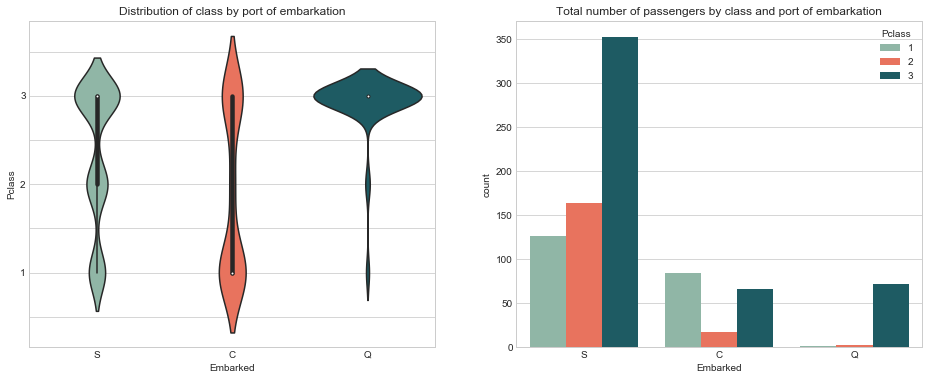

In [13]:
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(16,6))
# Violinplot to describe the relative distribution of Pclass for the three ports of embarkation
axis1.set_title('Distribution of class by port of embarkation')
axis1.set(yticklabels=['','',1,'',2,'',3])
sns.violinplot(y='Pclass',x='Embarked', data=data, ax=axis1, palette=("#8abca7","#FF6347", "#12646f"))
# Same as above, but in absolute terms
axis2.set_title('Total number of passengers by class and port of embarkation')
sns.countplot(x="Embarked", hue="Pclass", data=data,ax=axis2, palette=("#8abca7","#FF6347", "#12646f"))


As we can see, from the two plots, aside from Queenstown, there is not much to go on. Southhampton looks like what we would expect intuitively from the whole of society: lots of people from the lower class and fewer from the upper classes.
Queenstown practically only consists of poor people and Southhampton is a mix of poor and rich people, with not much in between. The violin plots suggest, that Queenstown is a good proxy for the 3rd class. In absolute terms however, this is not the case. In Southhampton, more than 4 times as many people from the 3rd class embarked the Titanic than in Queenstown.

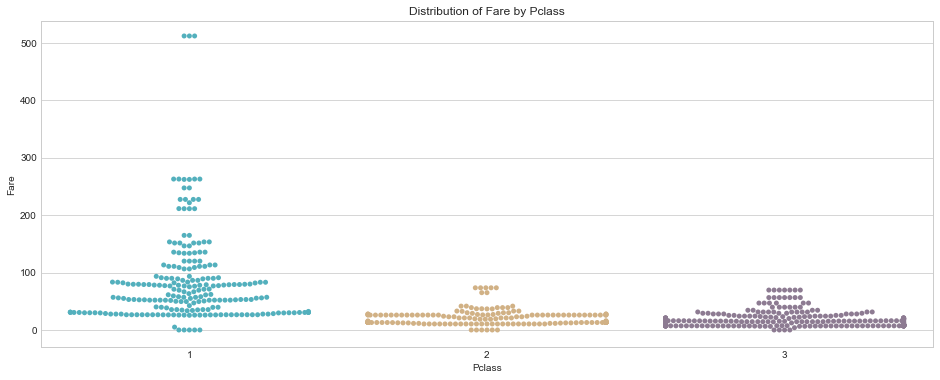

In [14]:
#Swarmplot to show correlation between Pclass and Fare
fig, (axis1) = plt.subplots(1,figsize=(16,6))
g=sns.swarmplot(y="Fare", x="Pclass", data=data)
g.set_title('Distribution of Fare by Pclass')


Here we see, that class 1, on average, clearly paid more for their fare than the other two classes. We could do a hypothesis test to check whether there are statistically significant differences between the ticket prices across classes. A t-test would be most obvious option. We can check if a t-test is a viable option by plotting the three distributions separately and then fitting normal distributions over the data:

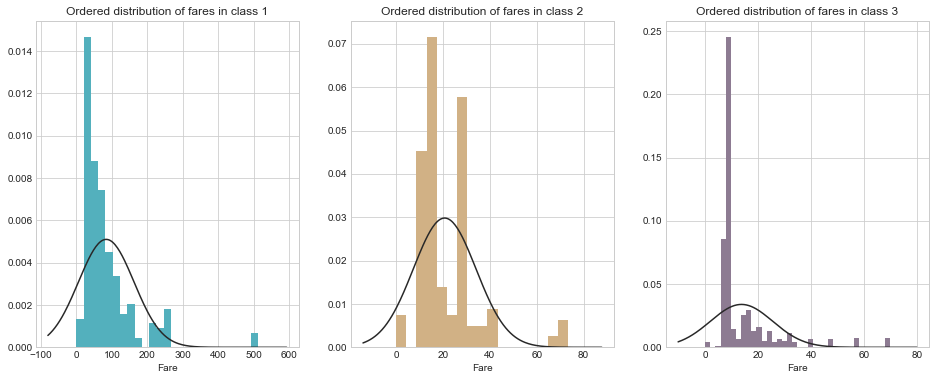

In [15]:
from scipy.stats import norm

#compare the distribution of fares with respective normal distributions within classes
fig, (axis1,axis2, axis3) = plt.subplots(1,3,figsize=(16,6))

axis1.set_title('Ordered distribution of fares in class 1')
sns.distplot(data.loc[data.Pclass==1]['Fare'], kde=False,fit=norm, hist=True,ax=axis1,hist_kws=dict(alpha=1))

axis2.set_title('Ordered distribution of fares in class 2')
sns.distplot(data.loc[data.Pclass==2]['Fare'], kde=False,fit=norm, hist=True,ax=axis2,hist_kws=dict(alpha=1),color="#d1b185")

axis3.set_title('Ordered distribution of fares in class 3')
sns.distplot(data.loc[data.Pclass==3]['Fare'], kde=False,fit=norm, hist=True,ax=axis3, hist_kws=dict(alpha=1),color= "#8d7b92")

We can see, that the distributions only roughly resemble a normal distribution. We can observe quite a few outliers, which could be due to differently priced subclasses of tickets within each class. A non-parametric test would probably be a safer option. We can look at this from a different angle by trying to fit a linear model on the data:

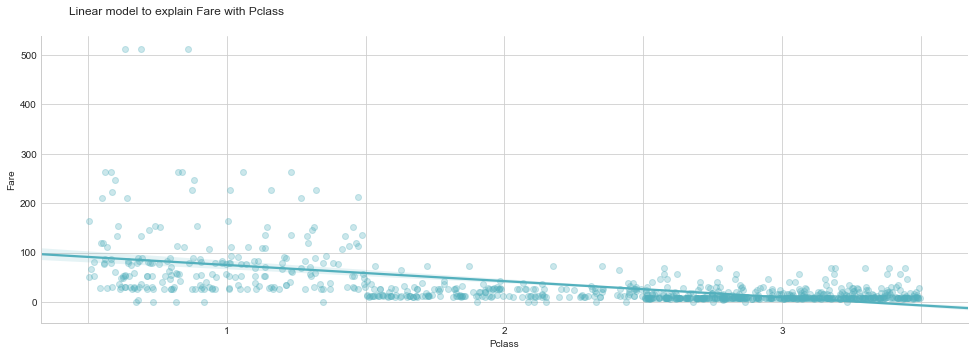

In [16]:
#linear regression to explain Fare using Pclass
g=sns.lmplot(x="Pclass", y="Fare", data=data, x_jitter=.5,scatter_kws=dict(alpha=0.3))
g.set(xticklabels=[0,'',1,'',2,'',3])
plt.subplots_adjust(top=.9,right=2.7)
g.fig.suptitle('Linear model to explain Fare with Pclass')


While the linear model obviously catches the right trend, it is not really a satisfying fit. Especially class 2 and 3 do not look as different as the model tries to suggest. We need to rely on statistical tests a suggested above to figure this out.


We still do not know exactly how the variable 'Fare' works. Is it per person or rather per cabin? One way to look at this is to group the data by cabin and class and then just look at standard deviations. That way, we immediately see whenever different ticket prices within one cabin occur.

        count      mean        std  min  25%       50%       75%         max
Pclass                                                                      
1        38.0  9.645108  58.169916  0.0  0.0  0.000000  0.000000  358.735918
2         5.0  0.647521   0.692196  0.0  0.0  0.497117  1.297112    1.443376
3         3.0  1.200407   2.079167  0.0  0.0  0.000000  1.800611    3.601222


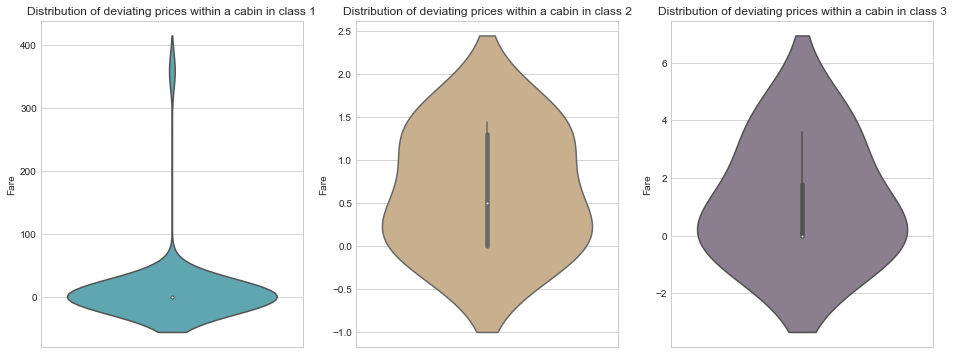

In [17]:
#group by cabin and class over standard deviations and then group again by class to see deviating prices per class 
print data.groupby(['Cabin','Pclass'])['Fare'].std().groupby(by='Pclass').describe()


#With the next line you can visualize that discounts and free tickets were only given to adult men in first class
#sns.violinplot(y=data.loc[(data.Pclass==1)&(data.woman_or_child=='no')].groupby(by='Cabin')['Fare'].std(),ax=axis1)

#Violinplots to show standard deviations of 'Fare' withing a cabin
fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(16,6))
axis1.set_title('Distribution of deviating prices within a cabin in class 1')
sns.violinplot(y=data.loc[data.Pclass==1].groupby(by='Cabin')['Fare'].std(),ax=axis1)
axis2.set_title('Distribution of deviating prices within a cabin in class 2')
sns.violinplot(y=data.loc[data.Pclass ==2].groupby(by='Cabin')['Fare'].std(),ax=axis2,color="#d1b185")
axis3.set_title('Distribution of deviating prices within a cabin in class 3')
sns.violinplot(y=data.loc[data.Pclass ==3].groupby(by='Cabin')['Fare'].std(),ax=axis3,color= "#8d7b92")

While the violin plots look promising, the table above tells us, that there were only 46 cabins were different ticket prices occured. Most of the data on cabins in class 2 and 3 is missing, so we can not really say anything about those results. In class one however, we see a few cases with very large deviations. An explanation could be special discounts or free passage in the VIP class. Since only men received those discounts, this seems to make sense. We can try to deal with this problem, by replacing different prices within a cabin with the average ticket price in that cabin. In the next graphic though, we can see that the effect is minuscule.

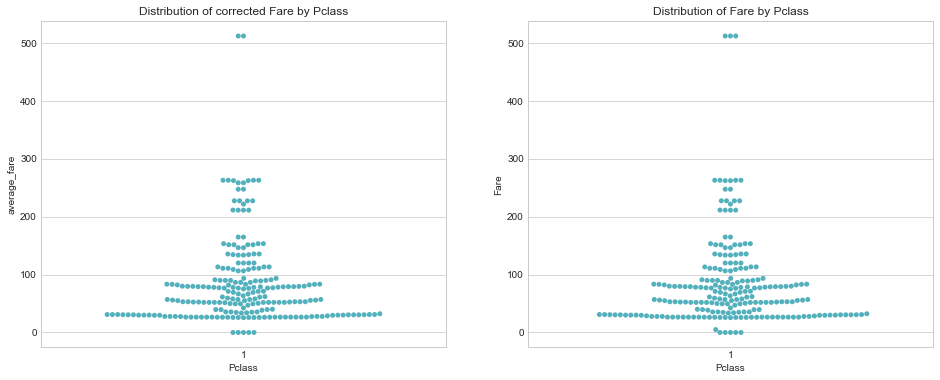

In [18]:
#prepare data for 'cleanfare'
grouped=data.groupby(by='Cabin')['Fare'].mean()
data['average_fare'] = data.Fare

def cleanfare(data, grouped):
    '''
    cleanfare replaces all individual ticket prices within all cabins 
    and replaces them with the average ticket price of that cabin.
    '''
    for cabin in grouped.index:
        data.loc[data.Cabin==cabin,'average_fare']= grouped[cabin]
cleanfare(data,grouped)

#Swarmplot to show correlation between Pclass and corrected fare for class one
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(16,6))
g=sns.swarmplot(y="average_fare", x=data.Pclass.loc[data.Pclass==1], data=data,ax=axis1)
g.set_title('Distribution of corrected Fare by Pclass')

#Swarmplot to show correlation between Pclass and Fare for class one
g=sns.swarmplot(y="Fare", x=data.Pclass.loc[data.Pclass==1], data=data,ax=axis2)
g.set_title('Distribution of Fare by Pclass')

We do not get anywhere with the cabin data. We could try the same thing with the 'Ticket' variable, but it turns out that there are many tickets, that span over multiple cabins and vice versa. In the end, too much is missing and without exact knowledge on discounts and free tickets, we can not draw exact conclusions from 'Fare'. 

Our efforts to find relationships between class, ticket price and port of embarkation have not been very successful.
While Queenstown is a great predictor for class 3 and a fare of over 100 only happens in class 1, class 2 can not at all be derived from our dataset. 

# Conclusions

We found strong evidence for 'women and children first' and could not construct Pclass from other variables. Note that we only worked with a sample of the real passenger data. There were 2224 (Wikipedia) people aborad when the ship sank, whereas our dataset only had 891 entries. Data on the crew would have been particularly interesting aswell. We also have too keep in mind, that the ship had designated areas for the three passenger classes. Since the titanic sank rather quickly, the location at the time of the crash of a given passenger probably had an impact on her survival rate. We found some convincing trends in the data, but there are some lurking variables, that we can not fully control for.